### Logistic Regression with L2 Regulatization

We know that the Logistic Regression can be regarded as a no-hidden-layer neural network with sigmoid a sigmoid activation function in it's output. In simple terms, it can be explained as applying a transformation to the output of a linear regression.

Mathematically, this the following:

$$
\begin{align}
\hat{y} = \sigma(XW + b) \\
\sigma(Z) = \frac{1}{1 + e^{-Z}}
\end{align}
$$

Where $X \in \mathbb{R}^{n \times p}$ is the feature matrix, $y \in \mathbb{R}^{n \times 1}$ is the target vector, $W \in \mathbb{R}^{p \times 1}$ is the weights vector, and $b \in \mathbb{R}^{n \times 1}$ is the bias vector. $Z$ stands for the output of the linear regression and thus, it has the output dimensions of it, $Z \in \mathbb{R}^{n \times 1}$ in this case.

Now, we will consider the regular Logistic Regression loss function (binary cross-entropy) for the optimization problem, however, we are going to add a constraint that bounds the $L_2$ norm of the weight vector to be less or equal than certain scalar k. Formally, this is as it follows:

$$
\begin{align*}
\underset{W, b}{min} \quad - \sum^{n}_{i=1} y_i\log{(\hat{y})} + (1 - y_i)\log{(1 - \hat{y})} \\
s.t. \quad W^TW \leq k
\end{align*}
$$

Then, the Lagrangian formulation of the problem will be the following:

$$
\underset{W, b}{min}\, \underset{\lambda \geq 0}{max} \quad L(W, b, \lambda) = BCE(y, \hat{y}) + \lambda(W^tW - k)
$$

Where we exchanged the commonly used $L$ notation for the loss in order to maintain our function notation clean.

### Imports

In [48]:
import random
import typing as t

import wandb
import torch
import numpy as np
import matplotlib.pyplot as plt

from collections import OrderedDict
from torch.nn import Module, Parameter
from torch.utils.data import TensorDataset, Subset, DataLoader

from copy import deepcopy
from torch.utils.data import random_split
from sklearn.datasets import load_breast_cancer

# Ensure Reproducibility
random.seed(777)
np.random.seed(777)
torch.manual_seed(777)
torch.backends.cudnn.deterministic = True

# Wandb Login
wandb.login()

wandb: Currently logged in as: doterog. Use `wandb login --relogin` to force relogin


True

In [2]:
import cooper

### Auxiliary Functions

In [56]:
def load_breast_cancer_data() -> TensorDataset:

    """Load the breast cancer dataset and return it as a torch tensor.

    Returns:
        TensorDataset: Breast cancer dataset."""

    breast_cancer = load_breast_cancer()

    X = torch.tensor(breast_cancer.data, dtype=torch.float32)
    y = torch.tensor(breast_cancer.target, dtype=torch.float32)

    return TensorDataset(X, y)


def split_data(dataset: torch.Tensor, ratio: float) -> t.Tuple[Subset, Subset, Subset]:

    """Split the data into training, validation, and test data.

    Args:
        data (torch.Tensor): The data to split.
        ratio (float): The ratio of the data to use for training, validation, and test.

    Returns:
        Tuple[torch.Tensor, torch.Tensor, torch.Tensor]: The training, validation, and test data."""

    n_samples = len(dataset)
    train_samples = int(np.ceil(n_samples * ratio))
    val_samples = int(np.ceil((n_samples - train_samples) * 0.5))
    test_samples = n_samples - train_samples - val_samples

    return random_split(dataset, [train_samples, val_samples, test_samples])


def set_optimizers(
    cmp: cooper.CMPState,
    params: t.List[torch.nn.Parameter],
    primal_lr: float,
    dual_lr: float,
) -> t.Tuple[cooper.LagrangianFormulation, cooper.ConstrainedOptimizer]:

    """Set the optimizers for the model.

    Args:
        cmp (cooper.CMPState): The CMP state.
        params (t.List[torch.nn.Parameter]): The parameters of the model.
        primal_lr (float): The learning rate for the primal optimizer.
        dual_lr (float): The learning rate for the dual optimizer.

    Returns:
        t.Tuple[cooper.LagrangianFormulation, cooper.ConstrainedOptimizer]: The lagrangian
            formulation and the constrained optimizer."""

    formulation = cooper.LagrangianFormulation(cmp)

    primal_optimizer = torch.optim.SGD(params, lr=primal_lr, momentum=0.7)
    dual_optimizer = cooper.optim.partial_optimizer(torch.optim.SGD, lr=dual_lr, momentum=0.7)

    coop = cooper.ConstrainedOptimizer(
        formulation=formulation,
        primal_optimizer=primal_optimizer,
        dual_optimizer=dual_optimizer,
    )

    return formulation, coop


def train_model(
    model: torch.nn.Module,
    is_constrained: bool,
    data_loader: DataLoader,
    optimizer: t.Union[cooper.ConstrainedOptimizer, torch.optim.Optimizer],
    num_epochs: int,
    criterion: torch.nn.modules.loss._Loss = None,
    cmp: cooper.CMPState = None,
    formulation: cooper.LagrangianFormulation = None,
    k: float = None,
) -> t.Tuple[torch.nn.Module, OrderedDict]:

    """Trains a model using the data_loader and the formulation, cmp, and coop objects for the
    optimization.

    Args:
        model (torch.nn.Module): The model to train.
        is_constrained (bool): Whether the model is constrained or not.
        data_loader (DataLoader): The data loader to use.
        optimizer (t.Union[cooper.ConstrainedOptimizer, torch.optim.Optimizer]): The optimizer to
            use.
        num_epochs (int): The number of epochs to train for.
        criterion (torch.nn.modules.loss._Loss): The loss function to use.
        cmp (cooper.CMPState): The CMP state to use.
        formulation (cooper.LagrangianFormulation): The formulation to use.
        k (float): The slack term of the inequality defects.

    Returns:
        torch.nn.Module: The trained model."""

    state_history = OrderedDict()

    iter_num = 0
    for epoch in range(num_epochs):
        for inputs, targets in data_loader:

            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()

            # Backward
            if is_constrained:
                lagrangian = formulation.composite_objective(cmp.closure, model, inputs, targets, k)
                formulation.custom_backward(lagrangian)
            else:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()

            # Update parameters
            if is_constrained:
                optimizer.step(cmp.closure, model, inputs, targets, k)
            else:
                optimizer.step()

            if iter_num % 5 == 0:
                if is_constrained:
                    state_history[iter_num] = {
                        'cmp': cmp.state,
                        'dual': deepcopy(formulation.state()),
                    }
                else:
                    state_history[iter_num] = {
                        'loss': loss.item(),
                    }

            iter_num += 1

    return model, state_history


def plot_constrained_state_history(state_history: OrderedDict) -> None:

    """Plot the state history.

    Args:
        state_history (OrderedDict): The state history to plot.
    """

    # Unpack values
    iters, loss_history = zip(
        *[(iter_num, _["cmp"].loss.item()) for iter_num, _ in state_history.items()]
    )

    mult_history = np.stack(
        [_["dual"][0].data.numpy() for _ in state_history.values()]
    )

    defect_history = np.stack(
        [_["cmp"].ineq_defect.data.numpy() for _ in state_history.values()]
    )

    # Plot
    _, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(15, 3))

    ax0.plot(iters, mult_history)
    ax0.set_title("Multipliers")

    ax1.plot(iters, mult_history, alpha=0.6)
    ax1.axhline(0.0, c="gray", alpha=0.2)
    ax1.set_title("Defects")

    ax2.plot(iters, loss_history)
    ax2.set_title("Objective")

    for ax in [ax0, ax1, ax2]:
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Value")

    [_.semilogx() for _ in (ax0, ax1, ax2)]
    plt.show()

def plot_unconstrained_state_history(state_history: OrderedDict) -> None:

    """Plots loss of unconstrained model.

    Args:
        state_history (OrderedDict):
    """

    iters, loss_history = zip(
        *[(iter_num, _["loss"]) for iter_num, _ in state_history.items()]
    )

    plt.figure(figsize=(5, 3))
    plt.plot(iters, loss_history)
    plt.title("Unconstrained Model Objective")
    plt.xlabel("Iteration")
    plt.ylabel("Value")
    plt.semilogx()
    plt.show()


def evaluate_model(model: torch.nn.Module, data_loader: DataLoader, mode: str) -> float:

    """Evaluate the model on the data.

    Args:
        model (torch.nn.Module): The model to evaluate.
        data_loader (DataLoader): The data loader to use.
        mode (str): The mode to use. Valid modes are "train", "val", and "test".

    Returns:
        float: The accuracy of the model on the data.
    """

    model.eval()

    with torch.no_grad():
        total, correct = 0, 0
        for inputs, targets in data_loader:
            pred_logits = model.forward(inputs)
            predicted = pred_logits > 0.5
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    wandb.log({mode + "_accuracy": correct / total})
    return correct * 100 / total

### Model and Optimization Problem

In [4]:
class LogisticRegression(torch.nn.Module):

    def __init__(self, input_size: int, output_size: int) -> None:
        """Initialize the model.

        Args:
            input_size (int): The size of the input.
            output_size (int): The size of the output.
        """
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_size, output_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass of the model.

        Args:
            x (torch.Tensor): The input data.

        Returns:
            torch.Tensor: The output of the model.
        """
        return torch.sigmoid(self.linear(x)).squeeze()

class NormConstrainedLogisticRegression(cooper.ConstrainedMinimizationProblem):
    def __init__(self):
        self.criterion = torch.nn.BCELoss()
        super().__init__(is_constrained=True)

    def closure(
        self,model: torch.nn.Module,
        inputs: torch.Tensor,
        targets: torch.Tensor,
        k: float,
    ) -> cooper.CMPState:
        """Compute the loss.

        Args:
            model (torch.nn.Module): The model to compute the loss for.
            inputs (torch.Tensor): The input data.
            targets (torch.Tensor): The target data.
            k (float): The slack term of the inequality defects.

        Returns:
            cooper.CMPState: The state of the CMP.
        """

        pred_logits = model.forward(inputs).squeeze()
        loss = self.criterion(pred_logits, targets)

        ineq_defect = torch.sum(torch.pow(model.linear.weight, 2)) - k
        return cooper.CMPState(loss=loss, ineq_defect=ineq_defect)

### Step 1: Load Data

In [5]:
dataset = load_breast_cancer_data()

print(f'Number of observations: {len(dataset)}')
print(f'Number of features: {dataset[0][0].shape[0]}')

Number of observations: 569
Number of features: 30


In [6]:
train_data, val_data, test_data = split_data(dataset, 0.6)

print(f'Nuumber of training samples: {len(train_data)}')
print(f'Number of validation samples: {len(val_data)}')
print(f'Number of testing samples: {len(test_data)}')

Nuumber of training samples: 342
Number of validation samples: 114
Number of testing samples: 113


### Step 2: Make Data Iterable

In [7]:
batch_size = 32
n_iters = 1000

In [8]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

### Step 3-5: Build Model, Instantiate Model, Instantiate Loss Class

In [9]:
model = LogisticRegression(dataset[0][0].shape[0], 1)
cmp = NormConstrainedLogisticRegression()

### Step 6: Instantiate Optimizer Class

In [10]:
primal_lr = 1e-3
dual_lr = 5e-3

formulation, coop = set_optimizers(cmp, model.parameters(), primal_lr, dual_lr)

### Step 7-8: Train and Evaluate Model

In [13]:
num_epochs = int(n_iters / (len(train_data) / batch_size))

#### Unconstrained Model

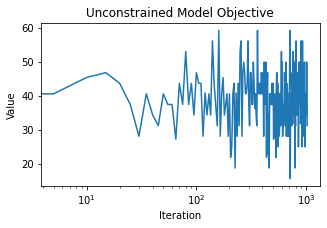

Train accuracy: 61.98830409356725
Validation accuracy: 67.54385964912281
Test accuracy: 60.176991150442475


In [43]:
# Train unconstrained model
is_constrained = False
optimizer = torch.optim.SGD(model.parameters(), lr=primal_lr)
criterion = torch.nn.BCELoss()

unc_model = LogisticRegression(dataset[0][0].shape[0], 1)

unc_model, unc_state_history = train_model(unc_model, is_constrained, train_loader, optimizer, num_epochs, criterion=criterion)

plot_unconstrained_state_history(unc_state_history)

unc_train_accuracy = evaluate_model(unc_model, train_loader, 'train')
unc_val_accuracy = evaluate_model(unc_model, val_loader, 'val')
unc_test_accuracy = evaluate_model(unc_model, test_loader, 'test')

print(f'Train accuracy: {unc_train_accuracy}')
print(f'Validation accuracy: {unc_val_accuracy}')
print(f'Test accuracy: {unc_test_accuracy}')

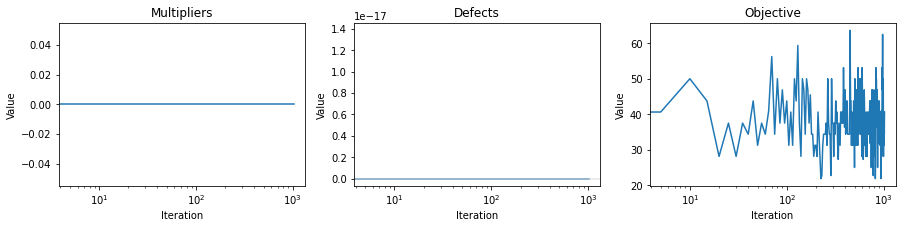

Train accuracy: 61.98830409356725
Validation accuracy: 67.54385964912281
Test accuracy: 60.176991150442475


In [39]:
# Train unconstrained model
is_constrained = True
optimizer = coop
k = 10

model, const_state_history = train_model(model, is_constrained, train_loader, optimizer,
                                                num_epochs, cmp=cmp, formulation=formulation, k=k)

plot_constrained_state_history(const_state_history)

const_train_accuracy = evaluate_model(model, train_loader)
const_val_accuracy = evaluate_model(model, val_loader)
const_test_accuracy = evaluate_model(model, test_loader)

print(f'Train accuracy: {const_train_accuracy}')
print(f'Validation accuracy: {const_val_accuracy}')
print(f'Test accuracy: {const_test_accuracy}')

In [57]:
def preparation(
    config: wandb.config,
) -> t.Tuple[DataLoader, DataLoader, DataLoader, torch.nn.Module, int]:

    """Prepares data and instances the model for training.

    Args:
        train_ratio (float): The ratio of the data to be used for training.
        batch_size (int): The batch size to use for training.
        n_iters (int): The number of iterations to train for.

    Returns:
        tuple: A tuple of the train loader, the validation loader, the test loader, the model, and
            the number of epochs to train it.
    """

    train_ratio, batch_size, n_iters = config.train_ratio, config.batch_size, config.n_iters

    dataset = load_breast_cancer_data()

    train_data, val_data, test_data = split_data(dataset, train_ratio)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

    model = LogisticRegression(dataset[0][0].shape[0], 1)

    num_epochs = int(n_iters / (len(train_data) / batch_size))

    return train_loader, val_loader, test_loader, model, num_epochs

def train(
    model: torch.nn.Module,
    train_loader: DataLoader,
    num_epochs: int,
    config: wandb.config,
) -> t.Tuple[torch.nn.Module, OrderedDict]:

    """Train the model.

    Args:
        model (torch.nn.Module): The model to train.
        train_loader (DataLoader): The data loader to use for training.
        num_epochs (int): The number of epochs to train for.
        is_constrained (bool): Whether to train the model constrained or unconstrained.
        unconst_lr (float, optional): The learning rate to use for the unconstrained model.
        primal_lr (float, optional): The learning rate to use for the primal variable.
        dual_lr (float, optional): The learning rate to use for the dual variable.
        k (int, optional): The slack term of the inequality defects.

    Returns:
        tuple: A tuple of the trained model and the state history."""

    is_constrained = config.is_constrained
    criterion = torch.nn.BCELoss
    wandb.watch(model, criterion, log="all", log_freq=10)

    if is_constrained:
        cmp = NormConstrainedLogisticRegression()
        formulation, optimizer = set_optimizers(cmp,
                                                model.parameters(),
                                                config.primal_lr,
                                                config.dual_lr)
        model, state_history = train_model(model,
                                            is_constrained,
                                            train_loader,
                                            optimizer,
                                            num_epochs,
                                            cmp=cmp,
                                            formulation=formulation,
                                            k=config.k)

    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=config.unconst_lr)

        model, state_history = train_model(model,
                                        is_constrained,
                                        train_loader,
                                        optimizer,
                                        num_epochs,
                                        criterion=criterion)

    return model, state_history

def experimentation_pipeline(hyperparameters: dict) -> torch.nn.Module:

    """Experimentation pipeline.

    Args:
        is_constrained (bool): Whether to train a constrained model.
        unconst_lr (float, optional): The learning rate to use for the unconstrained model.
        primal_lr (float, optional): The learning rate of the primal optimizer.
        dual_lr (float, optional): The learning rate of the dual optimizer.
        k (float, optional): The slack term of the inequality defects.
        batch_size (int, optional): The batch size.
        n_iters (int, optional): The number of iterations.
        train_ratio (float, optional): The ratio of the training set.

    Returns:
        torch.nn.Module: The trained model."""

    with wandb.init(project="first_tests", config=hyperparameters):

        config = wandb.config

        train_loader, val_loader, test_loader, model, num_epochs = preparation(config)

        model, state_history = train(model, train_loader, num_epochs, config)

        train_accuracy = evaluate_model(model, train_loader)
        val_accuracy = evaluate_model(model, val_loader)
        test_accuracy = evaluate_model(model, test_loader)

    return model


In [53]:
config = dict(
    is_constrained=False,
    primal_lr = 1e-3,
    dual_lr = 5e-3,
    k = 10,
    batch_size = 32,
    n_iters = 1000,
    train_ratio = 0.6,
)

model = experimentation_pipeline(config)

TypeError: '<' not supported between instances of 'NoneType' and 'float'